In [4]:
import camb


['In', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_ih', '_ii', '_iii', '_oh', 'camb', 'exit', 'get_ipython', 'quit', 's']


In [269]:
import numpy as np

from time import time
import sys
sys.path.append('/home/addis/unamed_code')
sys.path.append('/home/addis/unamed_code/Library')



# so the has theta binning endpoint approximation
import numpy as np
#from time import time # maybe add computation time feature
from itertools import combinations_with_replacement
import pickle
from numba import jit
import sys
sys.path.append('Library')
import base_funcs as bf

import get_field as gf
from matplotlib import pyplot as plt
import compute_grid_info as cgi

#field things!
path = '../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [287]:
#intialize class Bk 
def bk_new(delta,l,L,N_side,theta,grid_info,binning_info,rs=[0,0],exorder=0,dtype=np.complex64,threads=1,real=False,verbose=True):

        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,Ntri,in_k1,in_k2 = binning_info
        
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if real:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)

        #calulates G_i the sum over k_i Q_i fields etc
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z 
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum

        #so this is the the same as above but allows for n (or p) > 0
        #hence there is no sum over fields so two fields shape (((l+1)(l+2)/2),Nside,Nside,Nside)) is returned
        def Qpqrs2(delta,delta_k,xi,ki,l): # extends
            if l == 0:
                return delta_k # this is need for the way Pk_bisector is implemented
            N_side = int(len(delta[:,0,0]))
            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array
            
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z 
            #print(ind)
            kF = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            Q_ij = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            for i in range(len(ind)): # so iterates for each possible ij etc

                k_prod = np.prod(ki[ind[i]],axis=0) # sum ki kj etc arrays for each combination
                x_prod = np.prod(xi[ind[i]],axis=0) #configuration space parts e.g. xi xj
                #count distinct permutation for each combination
                kF[i] = bf.count_distinct_permutations(ind[i])*k_prod*delta_k #k1 terms
                Q_ij[i] = FFTW_fft(delta*x_prod) #delta_k2,delta_k3 convolved x terms

            return kF,Q_ij
        
        #Lengendre multipoles
        def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
            if l == 0:
                return delta_k
            if l==1:
                Q_x = Qpqrs(delta_x,xi,ki,l)
                return Q_x
            if l==2:
                Q_xx = Qpqrs(delta_x,xi,ki,l)
                return (3/2)*Q_xx - (1/2)*delta_k
            if l==3:
                Q_xx = Qpqrs(delta_x,xi,ki,l)
                return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
            if l==4:
                Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
            else:
                raise Exception(l,"l-multipole not implemented")


        # bispecrum with theta binning and legendre polynomials decomposition #with endpoint
        def Bk_endpoint_theta(delta,l):
            global FFT_number,iFFT_number
            FFT_number = 0
            iFFT_number = 0

            if verbose: print('nyquist frequency=',k_ny,'fundamental frequency=',k_f)
            delta_k = FFTW_fft(delta)
            
            #constants - e.g. see watkinson
            Npix = N_side**3
            V = L**3
            H = V/Npix
            const = H**3 *(1/V)

            delta_kk = delta_k*MAS  #get MAS_corrected field

            #calulate delta_lm - this needs to be done once for each harmonic
            F_lm = delta_lm(delta,delta_k,xi,ki,l)*MAS 

            fft_del_k1 = FFTW_ifft(np.where(in_k1,F_lm,0)) # ifft
            fft_del_k2 = FFTW_ifft(np.where(in_k2,delta_kk,0)) # ifft
            
            N_bins = len(theta)
            fft_del = np.zeros((N_bins,N_side,N_side,N_side),dtype=dtype_r) #create empty arrays for the iffts of each bins
            for i in range(N_bins): #for each bin a new FFT box is created to get Delta(n,k) and I(n,k) after being IFFTed
                ifftbox = np.where(In_bin[i],delta_kk,0)
                fft_del[i] = FFTW_ifft(ifftbox)

            #@jit(nopython=True)
            def discrete_sum(x):
                Bbin_lm = np.zeros(x,dtype=dtype_r)
                #loops over each bin to calculate bk
                for i in range(x):
                    Un_Bbin = np.sum((fft_del_k1*fft_del_k2*fft_del[i])) # numerator of watkinson estimator
                    Bbin_lm[i] =  const * Un_Bbin/Ntri[i]
                return Bbin_lm
            
            Bbin_lm = discrete_sum(N_bins)
            if verbose: print('Number of FFTs used=',FFT_number,'Number of iFFTs used=',iFFT_number)
            return (2*l+1)*Bbin_lm


        #for Amn(2) and Amn(3) sums when n > 0 or p > 0
        #does sums for G_k as well with shape (1,Nside,Nside,Nside)
        #@jit(nopython=True)
        #loops here are the most efficeint as we have large array not summed over too many things - numba is far slower!
        def Amn_sum(N_bins,f1,f2,f3,field2=True):
            Bbin = np.zeros(N_bins,dtype=dtype_r)
            if field2:
                #loops over each bin (and composite fields!) to calculate bk
                for i in range(N_bins):
                    for j in range(len(f1)):
                        Bbin[i] += np.sum((f1[j]*f2[j]*f3[i])) # sum over 3 now real space fields!
                        
            else:
                #loops over each bin (and composite fields!) to calculate bk
                for i in range(N_bins):
                    for j in range(len(f1)):
                        Bbin[i] += np.sum((f1[j]*f2*f3[i,j])) 
                        
            return Bbin
        
        #loops here are the most efficeint as we have large array not summed over too many things - numba is far slower!
        def Amn_sum_x2x3(N_bins,f1,f2,f3): # when no x1 involved in the sum!
            Bbin = np.zeros(N_bins,dtype=dtype_r)
            #loops over each bin (and composite fields!) to calculate bk
            for i in range(N_bins):
                for j in range(len(f2)):
                    Bbin[i] += np.sum((f1*f2[j]*f3[i,j])) # sum over 3 now real space fields!
                        
            return Bbin

        #@jit(nopython=True)  #just like Amn_sum but for n > 0 AND p > 0
        def Mixed_sum(N_bins,f1,f2,f3,ordering=True):
            #f1 shape (Num_terms(f2),Num_terms(f3),Nside,Nside,Nside)
            #f2 shape (Num_terms(f2),Nside,Nside,Nside)
            #f3 shape (N_bins,Num_terms(f3),Nside,Nside,Nside)

            Bbin = np.zeros(N_bins,dtype=dtype_r)
            #Nested loop over bins and then both the 2nd and 3rd fields for bk!
            if ordering:
                for i in range(N_bins):
                    for j in range(f2.shape[0]):
                        for k in range(f3.shape[1]):
                            Bbin[i] += np.sum((f1[j,k]*f2[j]*f3[i,k])) # sum over 3 now real space fields!
            else:
                for i in range(N_bins):
                    for j in range(f2.shape[0]):
                        for k in range(f3.shape[1]):
                            Bbin[i] += np.sum((f1[j,k]*f2[k]*f3[i,j])) # sum over 3 now real space fields!
                        
            return Bbin
        
        #this is pretty nice and beefy function used when we have powers of the dot products... #successor of Qpqrs2
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2)))
            
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) #

            return F_1,F_2
        
        def reshape69(arr,nobins=True):#this reshapes (xi.f)^2 function to (xi.f)(xi.g) saving redundant compuation
            if nobins:
                arr_shape = arr.shape[1:]#get underlying shape
                arr_new = np.zeros((9,*arr_shape),dtype=dtype_r)
                #now get stuff
                #[0,0]
                arr_new[0]= arr[0]
                #[0,1]
                arr_new[1] = (1/2)*arr[1]
                arr_new[3] = (1/2)*arr[1]
                #[0,2]
                arr_new[2] = (1/2)*arr[2]
                arr_new[6] = (1/2)*arr[2]
                #[1,1]
                arr_new[4] = arr[3]
                #[1,2]
                arr_new[5] = (1/2)*arr[4]
                arr_new[7] = (1/2)*arr[4]
                #[2,2]
                arr_new[8] = arr[5]
            else:
                arr_shape = arr.shape[2:]#get underlying shape
                arr_new = np.zeros((arr.shape[0],9,*arr_shape),dtype=dtype_r)

                #now get stuff
                #[0,0]
                arr_new[:,0]= arr[:,0]
                #[0,1]
                arr_new[:,1] = (1/2)*arr[:,1]
                arr_new[:,3] = (1/2)*arr[:,1]
                #[0,2]
                arr_new[:,2] = (1/2)*arr[:,2]
                arr_new[:,6] = (1/2)*arr[:,2]
                #[1,1]
                arr_new[:,4] = arr[:,3]
                #[1,2]
                arr_new[:,5] = (1/2)*arr[:,4]
                arr_new[:,7] = (1/2)*arr[:,4]
                #[2,2]
                arr_new[:,8] = arr[:,5]
            return arr_new
        
        
        # (k1.x_i)^l1 (x1.xi)^l2 #so new stuff needed for bispectrum - more like Qpqrs2
        # will returns probably 3,3
        #returns 2 arrays shape (Num_terms(l2),Num_terms(l1),N_side,N_side,N_side)
        def Fields_funcbk(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            #now all 3 fields the same length!
            F_1 = np.zeros((len(ind1),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array
            F_2 = np.zeros((len(ind1),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta/(x_norm**(l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                
                for j in range(len(ind1)): #for k1.xi part -no longer condensed
                    k_prod = np.prod(k1[ind1[j]],axis=0) # sum kx etc arrays for each combination
                    F_1[i,j] = bf.count_distinct_permutations(ind1[j])*k_prod*FFTW_fft(delta1*x_prod2) 
                    #x_prod = np.prod(xi[ind1[j]],axis=0) #sum xi etc
                    #F_2[i,j] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta*x_prod*x_prod2) 
                            
            return F_1,F_2
                            
        # (k1.x_1)^l1 (x1.x2)^l2 (x1.x3)^l2 
        #(k.x1)(x2.x1)(x3.x1)
        #mmm only really new bit is the F_1 bit being 
        def Fields_funcbk3(delta,ki,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            #now all 3 fields the same length!
            F_1 = np.zeros((len(ind2),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta/(x_norm**(l1+4*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.xi part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in range(len(ind2)): #for k1.xj part 
                    x_prod3 = np.prod(xi[ind2[i]],axis=0)
                    for k in range(len(ind1)): #for k1.xi1 part - condensed

                        k_prod = np.prod(ki[ind1[k]],axis=0) # sum kx etc arrays for each combination
                        x_prod = np.prod(xi[ind1[k]],axis=0) #sum xi etc
                        F_1[i,j] += bf.count_distinct_permutations(ind1[k])*k_prod*FFTW_fft(delta1*x_prod*x_prod2*x_prod3)
             
            return F_1

        #non-endpoint LOS - all multipoles
        # bispecrum with theta binning and legendre polynomials decomposition
        def Bk_theta(delta,l):
            if verbose: print('nyquist frequency=',k_ny,'fundamental frequency=',k_f)
            global FFT_number,iFFT_number
            FFT_number = 0
            iFFT_number = 0
            
            delta_k = FFTW_fft(delta)
            
            #constants - e.g. see watkinson 
            Npix = N_side**3
            V = L**3
            H = V/Npix
            const = H**3 *(1/V)
            
            delta_kk = delta_k*MAS  # deconvolve with MAS

            #iFFTs for Dirac_delta - get final fields
            ifft_F_k2 = FFTW_ifft(np.where(in_k2,delta_kk,0))

            N_bins = len(theta) #number of bins
            in_k3 = In_bin
            
            ifft_F_k3 = np.zeros((N_bins,N_side,N_side,N_side),dtype=dtype_r) #create empty arrays for the iffts of each bins
            for i in range(N_bins): #for each bin a new FFT box is created to get Delta(n,k) and I(n,k) after being IFFTed
                ifftbox = np.where(In_bin[i],delta_kk,0)
                ifft_F_k3[i] = FFTW_ifft(ifftbox) #delta_k3 for each k-bin
                
            Npix = N_side**3; V = L**3
            H = V/Npix
            const = H**3 *(1/V)
            #main computation...
            def main_func(l):
                if l == 0:
                    return bkmono

                Bk_lm = np.zeros((15,N_bins),dtype=dtype_r)
                if l==1:
                    # for: k1.x1
                    kQ1 = Qpqrs(delta/x_norm,xi,ki,1) 
                    ifft_G1_1 = FFTW_ifft(np.where(in_k1,kQ1*MAS,0)) # ifft
                    
                    Bk_lm[0] = Amn_sum(N_bins,ifft_G1_1[np.newaxis,...], ifft_F_k2[np.newaxis,...],ifft_F_k3)
                    r,s = rs #unpack r and s
                    
                    if exorder == 'mid':
                        #using the x1 + x2 + x3 = 3d
                        #k.x2
                        kF_k1,Q_k2 = Qpqrs2(delta/x_norm,delta_k,xi,ki,1)
   
                        ifft_kF_k1 = np.zeros((len(Q_k2),N_side,N_side,N_side),dtype=dtype_r)
                        ifft_F_Qk2 = np.zeros((len(Q_k2),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(Q_k2)):
                            ifft_kF_k1[j] = FFTW_ifft(np.where(in_k1,kF_k1[j]*MAS,0))
                            ifft_F_Qk2[j] = FFTW_ifft(np.where(in_k2,Q_k2[j]*MAS,0))
                            
                        Bk_lm[1] = Amn_sum(N_bins,ifft_kF_k1, ifft_F_Qk2,ifft_F_k3)
                        
                        #k.x3
                        ifft_F_Qk3 = np.zeros((N_bins,len(Q_k2),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(Q_k2)):
                            for i in range(N_bins):
                                ifft_F_Qk3[i,j] = FFTW_ifft(np.where(in_k3[i],Q_k2[j]*MAS,0))
                                
                        Bk_lm[2] = Amn_sum(N_bins,ifft_kF_k1, ifft_F_k2,ifft_F_Qk3,False)
                        #Bk_lm *= (1/3)
                        
                        
                    if exorder == 1:
                        
                        #this stuff is used in both r and s parts...
                        #fpr the - k. xi parts
                        kF_k, Q_ij = Qpqrs2(delta,FFTW_fft(delta/x_norm),xi,ki,1) #get field in k-space
                        ifft_kF_k1 = np.zeros((len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(kF_k)):
                            ifft_kF_k1[j] = FFTW_ifft(np.where(in_k1,kF_k[j]*MAS,0))
                        
                        #fpr the - x1 (x1.xi) parts
                        F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,1)
                        ifft_F_1 = np.zeros((len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(F_1)):
                            ifft_F_1[j] = FFTW_ifft(np.where(in_k1,F_1[j]*MAS,0))

                        if rs[0] > 0:
                            #for r k.x2
                            ifft_F_Qk2 = np.zeros((len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                            for j in range(len(Q_ij)):
                                ifft_F_Qk2[j] = FFTW_ifft(np.where(in_k2,Q_ij[j]*MAS,0))

                            Bk_lm[1] = rs[0]*Amn_sum(N_bins,ifft_kF_k1,ifft_F_Qk2,ifft_F_k3)
                        
                            #for: - r x1 (x1.x2)   #similar to stuff above but with Fields func rather than Qpqrs
                            F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,1)

                            ifft_F_2 = np.zeros((len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                            for j in range(len(F_1)):
                                ifft_F_2[j] = FFTW_ifft(np.where(in_k2,F_2[j]*MAS,0))

                            Bk_lm[3] = -rs[0]*Amn_sum(N_bins,ifft_F_1,ifft_F_2,ifft_F_k3)
                        
                        if rs[1] > 0:
                            #for s k.x3              
                            #uses kF_k1 from before and Q_ij
                            ifft_F_Qk3 = np.zeros((N_bins,len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                            for j in range(len(kF_k)):
                                for i in range(N_bins):
                                    ifft_F_Qk3[i,j] = FFTW_ifft(np.where(in_k3[i],Q_ij[j]*MAS,0))

                            Bk_lm[2] = rs[1]*Amn_sum(N_bins,ifft_kF_k1,ifft_F_k2,ifft_F_Qk3,False)

                            #for -s x1 (x1.x3) #similar to before but binning is now with k3
                            ifft_F_3 = np.zeros((N_bins,len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                            for j in range(len(kF_k)):
                                for i in range(N_bins):
                                    ifft_F_3[i,j] = FFTW_ifft(np.where(in_k3[i],F_2[j]*MAS,0))
                            
                            
                            Bk_lm[4] = -rs[1]*Amn_sum(N_bins,ifft_F_1,ifft_F_k2,ifft_F_3,False)
                            
                    
                    if exorder == 2:#should be careful about bf.count... as we reuse stuff but should be ok as little is of second order...-but CHECK!!!
                        #this is going to be fucking long but here we go hope it is interesting!
                        #can't split r and s now...
                        
                        #for the r(1+r+s)(k. x2) parts--------------------------------------------
                        kF_k, Q_ij = Qpqrs2(delta,FFTW_fft(delta/x_norm),xi,ki,1) #get field in k-space
                        ifft_kF_k1 = np.zeros((len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                        ifft_Q1_2 = np.zeros((len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(kF_k)):
                            ifft_kF_k1[j] = FFTW_ifft(np.where(in_k1,kF_k[j]*MAS,0))
                            ifft_Q1_2[j] = FFTW_ifft(np.where(in_k2,Q_ij[j]*MAS,0))
                            
                        Bk_lm[1] = r*(1+r+s)*Amn_sum(N_bins,ifft_kF_k1,ifft_Q1_2,ifft_F_k3)

                        #for s(1+r+s) k.x3             
                        #uses kF_k1 from before and Q_ij
                        ifft_Q1_3 = np.zeros((N_bins,len(Q_ij),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(kF_k)):
                            for i in range(N_bins):
                                ifft_Q1_3[i,j] = FFTW_ifft(np.where(in_k3[i],Q_ij[j]*MAS,0))

                        Bk_lm[2] = s*(1+r+s)*Amn_sum(N_bins,ifft_kF_k1,ifft_F_k2,ifft_Q1_3,False)
                        
                        #for  -r*(1+r+s) x1 (x1.x2) parts-------------------------------------------------
                        F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                        ifft_G1Q1_1 = np.zeros((len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(F_1)):
                            ifft_G1Q1_1[j] = FFTW_ifft(np.where(in_k1,F_1[j]*MAS,0))

                        Bk_lm[3] = -r*(1+r+s)*Amn_sum(N_bins,ifft_G1Q1_1,ifft_Q1_2,ifft_F_k3)          
                        
                        #for  -s*(1+r+s)*x1 (x1.x3) #similar to before but binning is now with k3
                        Bk_lm[4] = -s*(1+r+s)*Amn_sum(N_bins,ifft_G1Q1_1,ifft_F_k2,ifft_Q1_3,False)
                               
                        #ok so now for x1 (xi.x1)^2    v.similar to x1 (x1.x2) parts---------------
                        #for (3/2)* r**2 x1 (x2.x1)^2
                        F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,2)
                        ifft_G1Q2_1 = np.zeros((len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                        ifft_Q2_2 = np.zeros((len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(F_1)):
                            ifft_G1Q2_1[j] = FFTW_ifft(np.where(in_k1,F_1[j]*MAS,0))
                            ifft_Q2_2[j] = FFTW_ifft(np.where(in_k2,F_2[j]*MAS,0)) 

                        Bk_lm[9] = (3/2)* r**2*Amn_sum(N_bins,ifft_G1Q2_1,ifft_Q2_2,ifft_F_k3)          
                        
                        #for (3/2)* s**2 x1 (x1.x3)^2 #similar to before but binning is now with k3
                        ifft_Q2_3 = np.zeros((N_bins,len(F_1),N_side,N_side,N_side),dtype=dtype_r)
                        for j in range(len(F_1)):
                            for i in range(N_bins):
                                ifft_Q2_3[i,j] = FFTW_ifft(np.where(in_k3[i],F_2[j]*MAS,0))
                        
                        Bk_lm[10] = (3/2)* s**2*Amn_sum(N_bins,ifft_G1Q2_1,ifft_F_k2,ifft_Q2_3,False)
                        
                        #ok now for xi (xi.x1)----------------------------------------------   
                        #for -r^2 x2 (x1.x2)
                        F_1,F_2  = Fields_funcbk(delta,ki,xi,x_norm,1,1) # returns a (3,3,grid.shape)
                        ifft_kQ1_1 = np.zeros((F_1.shape[0],F_1.shape[1],N_side,N_side,N_side),dtype=dtype_r)    
                        for i in range((F_1.shape[0])):
                            for j in range(F_1.shape[1]):
                                ifft_kQ1_1[i,j] = FFTW_ifft(np.where(in_k1,F_1[i,j]*MAS,0))
                        
                        #reshape into (9,grid.shape)
                        Bk_lm[5] = -r**2 *Amn_sum(N_bins,ifft_kQ1_1.reshape((F_1.shape[0]*F_1.shape[1],N_side,N_side,N_side)),reshape69(ifft_Q2_2),ifft_F_k3)
                        
                        #for -s^2 x3 (x1.x3)   
                        #reshape into (N_bins,9,grid.shape)
                        Bk_lm[6] = -s**2 *Amn_sum(N_bins,ifft_kQ1_1.reshape((F_1.shape[0]*F_1.shape[1],N_side,N_side,N_side)),ifft_F_k2,reshape69(ifft_Q2_3,False),False)
                        
                        #ok now for xi (xj.x1) parts----------------------------------------------
                        #so we will have 3 different fields - but we can just reuse previous shit
                        #for -r s x3(x1.x2)
                        Bk_lm[7] = -r*s *Mixed_sum(N_bins,ifft_kQ1_1,ifft_Q1_2,ifft_Q1_3)
                        #for -r s x2(x1.x3)# same as above but kQ1 pairings are swapped!
                        Bk_lm[8] = -r*s *Mixed_sum(N_bins,ifft_kQ1_1,ifft_Q1_2,ifft_Q1_3,False)
                         
                        #ok now for the x1 (xi.xi)--------------------------------------------------
                        #for -(1/2) r^2 x1 (x2.x2)
                        F_1 = Qpqrs(delta/x_norm**3,xi,ki,1)
                        ifft_q1_1 = FFTW_ifft(np.where(in_k1,F_1*MAS,0))
                        F_2 = FFTW_fft(delta*x_norm**2)
                        ifft_xx_2 = FFTW_ifft(np.where(in_k2,F_2*MAS,0))    
     
                        Bk_lm[11] = -(1/2)*r**2 *Amn_sum(N_bins,ifft_q1_1[np.newaxis,...],ifft_xx_2[np.newaxis,...],ifft_F_k3)
                        #for -(1/2) s^2 x1 (x3.x3)
                        ifft_xx_3 = np.zeros((N_bins,N_side,N_side,N_side),dtype=dtype_r)    
                        for i in range(N_bins):
                            ifft_xx_3[i] = FFTW_ifft(np.where(in_k3[i],F_2*MAS,0))
                            
                        Bk_lm[12] =-(1/2)*s**2 *Amn_sum(N_bins,ifft_q1_1[np.newaxis,...],ifft_F_k2[np.newaxis,...],ifft_xx_3)
    
                        #ok now for -rs x1 (x2.x3)-------------------------------------------------------
                        Bk_lm[13] = - r*s*Amn_sum_x2x3(N_bins,ifft_q1_1,ifft_Q1_2,ifft_Q1_3)
                            
                        #ok now for the final large boi---------------------------------------------------
                        #3rs (k.x1)(x2.x1)(x3.x1)
                        F_1 = Fields_funcbk3(delta,ki,xi,x_norm,1,1)
                        ifft_GQQ_1 = np.zeros((F_1.shape[0],F_1.shape[1],N_side,N_side,N_side),dtype=dtype_r)    
                        for i in range((F_1.shape[0])):
                            for j in range(F_1.shape[1]):
                                ifft_GQQ_1[i,j] = FFTW_ifft(np.where(in_k1,F_1[i,j]*MAS,0))
                            
                        Bk_lm[14] = 3*r*s *Mixed_sum(N_bins,ifft_GQQ_1,ifft_Q1_2,ifft_Q1_3)
                
                return  const/Ntri*Bk_lm


            def Bk_legendre(l):
                if l == 0:
                    return bkmono#main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-self.mono)
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*self.mono)
                else:
                    raise "Multipole not implemented"

            Bbin_lm = Bk_legendre(l)
            if verbose: print('Number of FFTs used=',FFT_number,'Number of iFFTs used=',iFFT_number)
            return (2*l+1)*Bbin_lm
        
        #if even then calculate monopole    
        if l % 2 == 0:
            # just calculate the monopole - it useful
            bkmono =  Bk_endpoint_theta(delta,0)
            if l != 0:
                return Bk_theta(delta,l) 
        
        else:
            # this is to pick which estimator function to call! - based on LOS and l
            #self.mono = 0
            if  rs == [0,0]:
                return Bk_endpoint_theta(delta,l)
            else:
                return Bk_theta(delta,l)

In [288]:
#intialize class Bk 
def bk_full_new(delta,l,L,N_side,ks,grid_info,binning_info,rs=[0,0],exorder=0,dtype=np.complex64,threads=1,real=False,verbose=True):

        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,Ntri = binning_info
        
        
        N_bins = len(ks)
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if real:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)

        #calulates G_i the sum over k_i Q_i fields etc
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z 
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum

        #so this is the the same as above but allows for n (or p) > 0
        #hence there is no sum over fields so two fields shape (((l+1)(l+2)/2),Nside,Nside,Nside)) is returned
        def Qpqrs2(delta,delta_k,xi,ki,l): # extends
            if l == 0:
                return delta_k # this is need for the way Pk_bisector is implemented
            N_side = int(len(delta[:,0,0]))
            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array
            
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z 
            #print(ind)
            kF = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            Q_ij = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            for i in range(len(ind)): # so iterates for each possible ij etc

                k_prod = np.prod(ki[ind[i]],axis=0) # sum ki kj etc arrays for each combination
                x_prod = np.prod(xi[ind[i]],axis=0) #configuration space parts e.g. xi xj
                #count distinct permutation for each combination
                kF[i] = bf.count_distinct_permutations(ind[i])*k_prod*delta_k #k1 terms
                Q_ij[i] = FFTW_fft(delta*x_prod) #delta_k2,delta_k3 convolved x terms

            return kF,Q_ij

        #this is pretty nice and beefy function used when we have powers of the dot products... #successor of Qpqrs2
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2)))
            
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) #

            return F_1,F_2
        
        def reshape69(arr,count_distinct=False):#this reshapes (xi.f)^2 function to (xi.f)(xi.g) saving redundant compuation
            arr_shape = arr.shape[2:]#get underlying shape
            arr_new = np.zeros((arr.shape[0],9,*arr_shape),dtype=dtype_r)
            
            if count_distinct: #are the permutations added to this part or not?
                #now get stuff
                #[0,0]
                arr_new[:,0]= arr[:,0]
                #[0,1]
                arr_new[:,1] = arr[:,1]
                arr_new[:,3] = arr[:,1]
                #[0,2]
                arr_new[:,2] = arr[:,2]
                arr_new[:,6] = arr[:,2]
                #[1,1]
                arr_new[:,4] = arr[:,3]
                #[1,2]
                arr_new[:,5] = arr[:,4]
                arr_new[:,7] = arr[:,4]
                #[2,2]
                arr_new[:,8] = arr[:,5]
            else:
                #now get stuff
                #[0,0]
                arr_new[:,0]= arr[:,0]
                #[0,1]
                arr_new[:,1] = (1/2)*arr[:,1]
                arr_new[:,3] = (1/2)*arr[:,1]
                #[0,2]
                arr_new[:,2] = (1/2)*arr[:,2]
                arr_new[:,6] = (1/2)*arr[:,2]
                #[1,1]
                arr_new[:,4] = arr[:,3]
                #[1,2]
                arr_new[:,5] = (1/2)*arr[:,4]
                arr_new[:,7] = (1/2)*arr[:,4]
                #[2,2]
                arr_new[:,8] = arr[:,5]
            return arr_new
        
        
        # (k1.x_i)^l1 (x1.xi)^l2 #so new stuff needed for bispectrum - more like Qpqrs2
        # will returns probably 3,3
        #returns 2 arrays shape (Num_terms(l2),Num_terms(l1),N_side,N_side,N_side)
        def Fields_funcbk(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            #now all 3 fields the same length!
            F_1 = np.zeros((len(ind1),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array
            F_2 = np.zeros((len(ind1),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta/(x_norm**(l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                
                for j in range(len(ind1)): #for k1.xi part -no longer condensed
                    k_prod = np.prod(k1[ind1[j]],axis=0) # sum kx etc arrays for each combination
                    F_1[i,j] = bf.count_distinct_permutations(ind1[j])*k_prod*FFTW_fft(delta1*x_prod2) 
                    #x_prod = np.prod(xi[ind1[j]],axis=0) #sum xi etc
                    #F_2[i,j] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta*x_prod*x_prod2) 
                            
            return F_1,F_2
                            
        # (k1.x_1)^l1 (x1.x2)^l2 (x1.x3)^l2 
        #(k.x1)(x2.x1)(x3.x1)
        #mmm only really new bit is the F_1 bit being 
        def Fields_funcbk3(delta,ki,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            #now all 3 fields the same length!
            F_1 = np.zeros((len(ind2),len(ind2),N_side,N_side,N_side_r),dtype=dtype) # create empty array

            delta1 = delta/(x_norm**(l1+4*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.xi part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in range(len(ind2)): #for k1.xj part 
                    x_prod3 = np.prod(xi[ind2[i]],axis=0)
                    for k in range(len(ind1)): #for k1.xi1 part - condensed

                        k_prod = np.prod(ki[ind1[k]],axis=0) # sum kx etc arrays for each combination
                        x_prod = np.prod(xi[ind1[k]],axis=0) #sum xi etc
                        F_1[i,j] += bf.count_distinct_permutations(ind1[k])*k_prod*FFTW_fft(delta1*x_prod*x_prod2*x_prod3)
             
            return F_1

        #Lengendre multipoles
        def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
            if l == 0:
                return delta_k
            if l==1:
                Q_x = Qpqrs(delta_x,xi,ki,l)
                return Q_x
            if l==2:
                Q_xx = Qpqrs(delta_x,xi,ki,l)
                return (3/2)*Q_xx - (1/2)*delta_k
            if l==3:
                Q_xx = Qpqrs(delta_x,xi,ki,l)
                return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
            if l==4:
                Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
            else:
                raise Exception(l,"l-multipole not implemented")

        # bispecrum with theta binning and legendre polynomials decomposition #with endpoint
        def Bk_endpoint_full(delta,l):
            global FFT_number,iFFT_number
            FFT_number = 0
            iFFT_number = 0

            if verbose: print('nyquist frequency=',k_ny,'fundamental frequency=',k_f)
            delta_k = FFTW_fft(delta)
            
            #constants - e.g. see watkinson
            Npix = N_side**3
            V = L**3
            H = V/Npix
            const = H**3 *(1/V)
            
            fft_del = ifft_field(delta_k)
            if l != 0:
                #calulate delta_lm - this needs to be done once for each harmonic
                F_lm = delta_lm(delta,delta_k,xi,ki,l)
                fft_del1 = ifft_field(F_lm)
            else:
                fft_del1 = fft_del

            #compute sum 
            Bbin_lm = ifft_sum(ifftbox1,ifftbox,ifftbox)
            if verbose: print('Number of FFTs used=',FFT_number,'Number of iFFTs used=',iFFT_number)
            return (2*l+1)*Bbin_lm
        
        def ifft_field(field,single_field=True):
            if single_field:
                ifft_F = np.zeros((N_bins,N_side,N_side,N_side),dtype=dtype_r) #create empty arrays for the iffts of each bins
                for i in range(N_bins):#for each bin a new FFT box is created to get I(n,k) after being IFFTed
                    ifft_F[i] = FFTW_ifft(np.where(In_bin[i],field*MAS,0))
            else:
                ifft_F = np.zeros((N_bins,field.shape[0],N_side,N_side,N_side),dtype=dtype_r) #create empty arrays for the iffts of each bins
                for i in range(N_bins):#for each bin a new FFT box is created to get I(n,k) after being IFFTed
                    for j in range(field.shape[0]):
                        ifft_F[i,j] = FFTW_ifft(np.where(In_bin[i],field[j]*MAS,0))
            return ifft_F
        
        def ifft_sum(field1,field2,field3,multifield =0 ): # does sum over fields where there are possible closed triangles...
            
            Bk_lm = np.zeros((N_bins,N_bins,N_bins),dtype=dtype_r)
            if multifield == 0: 
                for i in range(N_bins):
                    for j in range(i+1):
                        if i > 2*j:
                            continue
                        for k in range(j+1):
                            if i > j+k:
                                continue
                            Bk_lm[i,j,k] = np.sum(field1[i]*field2[j]*field3[k])
                            
            if multifield == 1: # so if field is composite i.e. has shape (N_bins,N,N_side,N_side,N_side)
                for i in range(N_bins):
                    for j in range(i+1):
                        if i > 2*j:
                            continue
                        for k in range(j+1):
                            if i > j+k:
                                continue
                            for m in range(field1.shape[1]):
                                Bk_lm[i,j,k] = np.sum(field1[i,m]*field2[j,m]*field3[k])
            
            if multifield == 2:
                for i in range(N_bins):
                    for j in range(i+1):
                        if i > 2*j:
                            continue
                        for k in range(j+1):
                            if i > j+k:
                                continue
                            for m in range(field1.shape[1]):
                                Bk_lm[i,j,k] = np.sum(field1[i,m]*field2[j]*field3[k,m])
            return Bk_lm
        
        def ifft_mixed_sum(field1,field2,field3,which = 1): # does sum over fields where there are possible closed triangles...
            
            Bk_lm = np.zeros((N_bins,N_bins,N_bins),dtype=dtype_r)
            if which == 1: 
                for i in range(N_bins):
                    for j in range(i+1):
                        if i > 2*j:
                            continue
                        for k in range(j+1):
                            if i > j+k:
                                continue
                            for m in range(field1.shape[1]):
                                for n in range(field1.shape[2]):
                                    Bk_lm[i,j,k] = np.sum(field1[i,m,n]*field2[j,m]*field3[k,n])
            elif which == 2: 
                for i in range(N_bins):
                    for j in range(i+1):
                        if i > 2*j:
                            continue
                        for k in range(j+1):
                            if i > j+k:
                                continue
                            for m in range(field1.shape[1]):
                                for n in range(field1.shape[2]):
                                    Bk_lm[i,j,k] = np.sum(field1[i,m,n]*field2[j,n]*field3[k,m])
            
            else:
                raise Exception("meed to be option 1 or 2!")
                            
            return Bk_lm
        
        def ifft_sum_x2x3(field1,field2,field3): # does sum over fields where there are possible closed triangles...
            Bk_lm = np.zeros((N_bins,N_bins,N_bins),dtype=dtype_r)
            for i in range(N_bins):
                for j in range(i+1):
                    if i > 2*j:
                        continue
                    for k in range(j+1):
                        if i > j+k:
                            continue
                        for m in range(field2.shape[1]):
                                Bk_lm[i,j,k] = np.sum(field1[i]*field2[j,m]*field3[k,m])
                            
            return Bk_lm
        
        
        #non-endpoint LOS - all multipoles
        # bispecrum with theta binning and legendre polynomials decomposition
        def Bk_full(delta,l):
            if verbose: print('nyquist frequency=',k_ny,'fundamental frequency=',k_f)
            global FFT_number,iFFT_number
            FFT_number = 0
            iFFT_number = 0
            
            delta_k = FFTW_fft(delta)
            
            #constants - e.g. see watkinson 
            Npix = N_side**3; V = L**3
            H = V/Npix
            const = H**3 *(1/V)
            
            #main computation...
            def main_func(l):
                if l == 0:
                    return bkmono

                if l==1:
                    
                    #set up the first fields
                    kQ1 = Qpqrs(delta/x_norm,xi,ki,1) 
                    ifft_G1_1 = ifft_field(kQ1) # ifft
                    ifft_F = ifft_field(delta_k)
                    
                    # for: k1.x1
                    Bk_lm = ifft_sum(ifft_G1_1,ifft_F,ifft_F)
                    
                    # ok so now consider if we outside d = x1
                    if exorder == 'mid': # so here we compute the other endpoints as it were...
                        #using the x1 + x2 + x3 = 3d
                        
                        Bk_lm1 = np.zeros((3,N_bins,N_bins,N_bins),dtype=dtype_r) # I want 3 results from this as the other 2 endpoints are useful to have...
                        Bk_lm1[0] = Bk_lm
                        
                        kF_k1,Q_ij_x = Qpqrs2(delta/x_norm,delta_k,xi,ki,1)
                        
                        ifft_kF = ifft_field(kF_k1,False)
                        ifft_Q1_x = ifft_field(Q_ij_x,False)

                        #k.x2    
                        Bk_lm1[1] = ifft_sum(ifft_kF,ifft_Q1_x,ifft_F,1)
                        
                        #k.x3   
                        Bk_lm1[2] = ifft_sum(ifft_kF,ifft_F,ifft_Q1_x,2)
                        
                        Bk_lm = Bk_lm1
                        
                    r,s = rs #unpack r and s    
                    if exorder == 1:
                        #this stuff is used in both r and s parts...
                        #for the - k. xi parts
                        kF_k, Q_ij = Qpqrs2(delta,FFTW_fft(delta/x_norm),xi,ki,1) #get field in k-space
                        ifft_kF_x = ifft_field(kF_k,False)
                        ifft_Q1 = ifft_field(Q_ij,False)
                        
                        #for the - x1 (x1.xi) parts
                        F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,1)
                        ifft_G1Q1_x3 = ifft_field(F_1,False)

                        if r > 0:
                            #for r k.x2
                            Bk_lm += r*ifft_sum(ifft_kF_x,ifft_Q1,ifft_F,1)
                        
                            #for: - r x1 (x1.x2)   #similar to stuff above but with Fields func rather than Qpqrs
                            Bk_lm += -r*ifft_sum(ifft_G1Q1_x3,ifft_Q1,ifft_F,1)
                        
                        if s > 0:
                            #for s k.x3              
                            #uses kF_k1 from before and Q_ij
                            Bk_lm += s*ifft_sum(ifft_kF_x,ifft_F,ifft_Q1,2)

                            #for -s x1 (x1.x3) #similar to before but binning is now with k3
                            Bk_lm += -s*ifft_sum(ifft_G1Q1_x3,ifft_F,ifft_Q1,2)
                            
                    
                    if exorder == 2:#should be careful about bf.count... as we reuse stuff but should be ok as little is of second order...-but CHECK!!!
                        #this is going to be fucking long but here we go hope it is interesting!
                        #can't split r and s now...
                        
                        kF_k, Q_ij = Qpqrs2(delta,FFTW_fft(delta/x_norm),xi,ki,1) #get field in k-space
                        ifft_kF_x = ifft_field(kF_k,False)
                        ifft_Q1 = ifft_field(Q_ij,False)
                        
                        Bk_lm1 = np.zeros((15,N_bins,N_bins,N_bins),dtype=dtype_r)
                        Bk_lm1[0] = Bk_lm
                        
                        #for r(1+r+s) k.x2
                        Bk_lm1[1] = r*(1+r+s)*ifft_sum(ifft_kF_x,ifft_Q1,ifft_F,1)
                        
                        #for s(1+r+s) k.x3           
                        Bk_lm1[2] = s*(1+r+s)*ifft_sum(ifft_kF_x,ifft_F,ifft_Q1,2)
                         
                        #for the - x1 (x1.xi) parts-------------------------------------------------
                        F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,1)
                        ifft_G1Q1_x3 = ifft_field(F_1,False)
                        
                        #for  -r*(1+r+s) x1 (x1.x2) parts
                        Bk_lm1[3] = -r*(1+r+s)*ifft_sum(ifft_G1Q1_x3,ifft_Q1,ifft_F,1)         
                        
                        #for  -s*(1+r+s)*x1 (x1.x3) #similar to before but binning is now with k3
                        Bk_lm1[4] = -s*(1+r+s)*ifft_sum(ifft_G1Q1_x3,ifft_F,ifft_Q1,2)
                               
                        #ok so now for x1 (xi.x1)^2    v.similar to x1 (x1.x2) parts--------------- 
                        F_1,F_2  = Fields_func(delta,ki,xi,x_norm,1,2)
                        ifft_G1Q2_x5 = ifft_field(F_1,False)
                        ifft_Q2 = ifft_field(F_2,False)
                        
                        #for (3/2)* r**2 x1 (x2.x1)^2
                        Bk_lm1[5] += (3/2)* r**2*ifft_sum(ifft_G1Q2_x5,ifft_Q2,ifft_F,1)          
                        
                        #for (3/2)* s**2 x1 (x1.x3)^2 #similar to before but binning is now with k3
                        Bk_lm1[6] += (3/2)* s**2*ifft_sum(ifft_G1Q2_x5,ifft_F,ifft_Q2,2)
                        
                        #ok now for xi (xi.x1)------------------------------------------------------
                        F_1,F_2  = Fields_funcbk(delta,ki,xi,x_norm,1,1) # returns a (3,3,grid.shape)
                        ifft_Q1k_x3 = ifft_field(F_1.reshape((F_1.shape[0]*F_1.shape[1],N_side,N_side,N_side)),False)#reshape into (9,grid.shape)  
                                                
                        #for -r^2 x2 (x1.x2)
                        Bk_lm1[7] = -r**2 *ifft_sum(ifft_Q1k_x3,reshape69(ifft_Q2),ifft_F,1)
                        
                        #for -s^2 x3 (x1.x3)  
                        Bk_lm1[8] = -s**2 *ifft_sum(ifft_Q1k_x3,ifft_F,reshape69(ifft_Q2),2)
                        
                        #ok now for xi (xj.x1) parts----------------------------------------------
                        #for -r s x3(x1.x2)
                        Bk_lm1[9] = -r*s *ifft_mixed_sum(ifft_Q1k_x3.reshape((N_bins,3,3,N_side,N_side,N_side)),ifft_Q1,ifft_Q1,2)
                        #for -r s x2(x1.x3)# same as above but kQ1 pairings are swapped!
                        Bk_lm1[10] = -r*s *ifft_mixed_sum(ifft_Q1k_x3.reshape((N_bins,3,3,N_side,N_side,N_side)),ifft_Q1,ifft_Q1,1)
                         
                        #ok now for the x1 (xi.xi)-------------------------------------------------- 
                        F_1 = Qpqrs(delta/x_norm**3,xi,ki,1)
                        ifft_G_x3 = ifft_field(F_1)
                        F_2 = FFTW_fft(delta*x_norm**2)
                        ifft_xx = ifft_field(F_2)
                        
                         #for -(1/2) r^2 x1 (x2.x2)
                        Bk_lm1[11] = -(1/2)*r**2 *ifft_sum(ifft_G_x3,ifft_xx,ifft_F)
                        
                        #for -(1/2) s^2 x1 (x3.x3)
                        Bk_lm1[12] = -(1/2)*s**2 *ifft_sum(ifft_G_x3,ifft_F,ifft_xx)
                        
                        #ok now for -rs x1 (x2.x3)-------------------------------------------------------
                        Bk_lm1[13] = - r*s*ifft_sum_x2x3(ifft_G_x3,ifft_Q1,ifft_Q1)
                            
                        #ok now for the final large boi---------------------------------------------------
                        #3rs (k.x1)(x2.x1)(x3.x1)
                        #ok so now we can reuse field1 from the x1 (x2.x1)^2 part but need to reshape...
                        #is true as permutations were added to the non x1 part
                        ifft_GQQ_x5 = reshape69(ifft_G1Q2_x5,True).reshape((N_bins,3,3,N_side,N_side,N_side))
                        
                        Bk_lm1[14] = 3*r*s *ifft_mixed_sum(ifft_GQQ_x5,ifft_Q1,ifft_Q1)
                            
                return  const/Ntri*Bk_lm1


            def Bk_legendre(l):
                if l == 0:
                    return bkmono#main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-self.mono)
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*self.mono)
                else:
                    raise "Multipole not implemented"

            Bbin_lm = Bk_legendre(l)
            if verbose: print('Number of FFTs used=',FFT_number,'Number of iFFTs used=',iFFT_number)
            return (2*l+1)*Bbin_lm
        
        #if even then calculate monopole    
        if l % 2 == 0:
            # just calculate the monopole - it useful
            bkmono =  Bk_endpoint_full(delta,0)
            if l != 0:
                return Bk_full(delta,l) 
        
        else:
            # this is to pick which estimator function to call! - based on LOS and l
            #self.mono = 0
            if  rs == [0,0]:
                return Bk_endpoint_full(delta,l)
            else:
                return Bk_full(delta,l)

In [50]:
ds = np.arange(9).reshape((3,3))
print(ds.T)

[[0 3 6]
 [1 4 7]
 [2 5 8]]


In [4]:
def get_triangles(N_k):
    triangles = np.zeros((N_k,N_k,N_k))
    for i in range(N_k)[::-1]:
        for j in range(i+1)[::-1]:
            if i > 2*j:
                continue
            for k in range(j+1)[::-1]:
                if i > j+k:
                    continue
                triangles[i,j,k] = True
    
    return np.where(triangles==0,False,True)
triangles = get_triangles(10)

In [5]:
#get quick field
realisation = str(10039)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=-500'+ '.npy') #load field
#np.load('Quijote_fields/' + realisation + '_' + red_info + '_' + str(Nside) + 'LOS=Center' + '.npy') #load field

Nside=128
L=1000

In [6]:
%%time
rfft=False
order=2
obs_pos=(500,500,-500)
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)  # so call 
xi,xi_unorm,ki,k_mag,MAS,k_f,k_ny = grid_info

CPU times: user 3.56 s, sys: 126 ms, total: 3.69 s
Wall time: 3.7 s


In [289]:
%%time
theta= np.linspace(0,np.pi,10)
k1 = 0.06
k2 = 0.04
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

dtype=np.complex64
s=1               #units of 2*k_f
threads=6
binning_info1 = cgi.bk_theta_compute_bins(k1,k2,theta,Nside,s,grid_info[3],grid_info[5],dtype,threads,rfft)
#In_bin,Ntri,in_k1,in_k2


CPU times: user 2.67 s, sys: 82.9 ms, total: 2.75 s
Wall time: 481 ms


In [315]:
%%time
rs = [1,0]
verbose =True
l = 1
exorder = 2
test2 = bk_new(field_tmp,l,L,Nside,theta,grid_info,binning_info1,rs,exorder,dtype,threads,rfft,verbose)

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 84 Number of iFFTs used= 153
CPU times: user 1min 31s, sys: 6.56 s, total: 1min 38s
Wall time: 23.5 s


In [295]:
ks=np.arange(0.01,0.08,k_f)
binning_info = cgi.bk_full_compute_bins(ks,Nside,s,grid_info[3],grid_info[5],dtype,threads,rfft)

In [301]:
%%time
rs = [1,0]
verbose =True
l = 1
exorder = 2
test22 = bk_full_new(field_tmp,l,L,Nside,ks,grid_info,binning_info,rs,exorder,dtype,threads,rfft,verbose)

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 57 Number of iFFTs used= 408
CPU times: user 4min 28s, sys: 9.04 s, total: 4min 37s
Wall time: 2min 46s


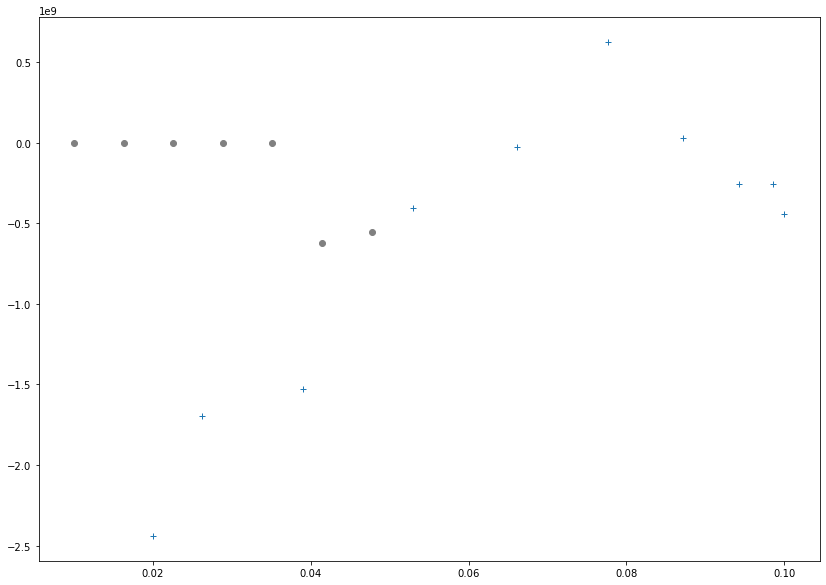

In [313]:
plt.figure(figsize=(14,10))
for i in range(7):
    #plt.plot(ks[i],testmid[1][i,i,i].imag,'o',color='black')
    #plt.plot(ks[i],test2[0][i,i,i].imag,'o',color='blue')
    plt.plot(ks[i],np.sum(test22[:2],axis=0)[8,i,5].imag,'o',color='grey')
    #plt.plot(ks[i],test2[3][8,5,i].imag/2,'o',color='blue')

plt.plot(k3,np.sum(test2[:2],axis=0).imag,'+')
    #plt.plot(ks[i],test2[5][i,i,i].imag,'o',color='grey')
    #plt.plot(ks[i],test2[7][i,i,i].imag,'o',color='blue')
    #plt.plot(ks[i],test2[11][i,i,i].imag,'o',color='green')

    
    #plt.plot(ks[i],testmid[1][i,i,i].imag,'o',color='black')
    #plt.plot(ks[i],testmid[2][i,i,i].imag,'.',color='blue')
    #plt.plot(ks[i],test1[i,i,i].imag,'o',color='green')
    #plt.plot(ks[i],np.sum(test2[0:4],axis=0)[i,i,i].imag,'o',color='red')
    #plt.plot(ks[i],np.sum(testmid,axis=0)[i,i,i].imag/3,'o',color='black')
    

In [318]:
%%time
rs = [1/3,1/3]
verbose =True
l = 1
exorder = 2
#test2 = bk_new(field_tmp,l,L,Nside,theta,grid_info,binning_info,rs,exorder,dtype,threads,rfft,verbose)
exorder = 1
#test = bk_new(field_tmp,l,L,Nside,theta,grid_info,binning_info,rs,exorder,dtype,threads,rfft,verbose)
exorder = 'mid'
testmid = bk_new(field_tmp,l,L,Nside,theta,grid_info,binning_info1,rs,exorder,dtype,threads,rfft,verbose)

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 7 Number of iFFTs used= 48
CPU times: user 17.5 s, sys: 1.23 s, total: 18.7 s
Wall time: 3.4 s


ValueError: x and y must have same first dimension, but have shapes (10,) and (7, 7, 7)

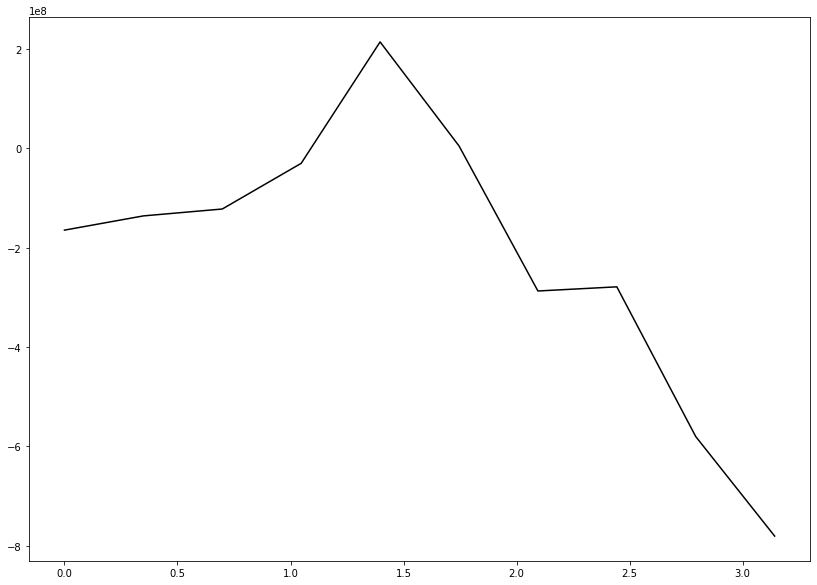

In [316]:
plt.figure(figsize=(14,10))
#plt.plot(theta,test[0].imag,'k')
plt.plot(theta,test2[0].imag,'k')
#plt.plot(theta,test2[1].imag)
#plt.plot(theta,test2[2].imag)
#plt.plot(theta,test2[3].imag)
#plt.plot(theta,test2[4].imag)
#plt.plot(theta,test2[5].imag)
#plt.plot(theta,test2[6].imag)
#plt.plot(theta,test2[7].imag)
#plt.plot(theta,test2[8].imag)
#plt.plot(theta,test2[9].imag)
#plt.plot(theta,test2[10].imag)
#plt.plot(theta,test2[11].imag)
#plt.plot(theta,test2[12].imag)
#plt.plot(theta,test2[13].imag)
#plt.plot(theta,test2[14].imag)

#plt.plot(theta,testmid[1].imag,'r')
#plt.plot(theta,testmid[2].imag,'r')


plt.plot(theta,np.sum(test[:].imag,axis=0),'--',label='1st order')
plt.plot(theta,np.sum(test2[:].imag,axis=0),'--',label='2nd order ')
plt.plot(theta,(1/3)*np.sum(testmid[:10].imag,axis=0),'--',label='1st order mid')


plt.legend()
plt.plot(theta,np.zeros_like(theta),linestyle='-.', color = 'black')
plt.axvline(x = 2/3 *np.pi, linestyle='-.', color = 'black')
plt.ylim(-0.8e+9,0.8e+9)
#plt.xlim(2,2.2)

(2.0, 2.2)

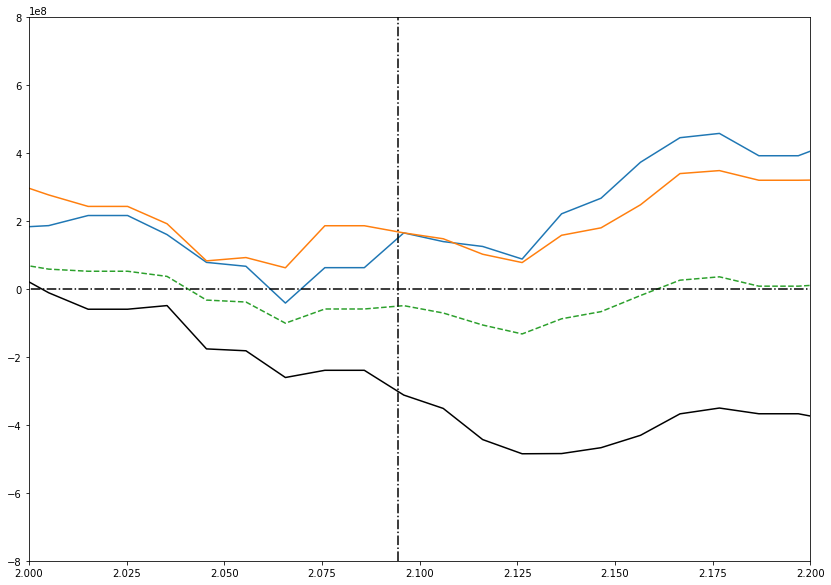

In [211]:
plt.figure(figsize=(14,10))
plt.plot(theta,testmid[0].imag,'k')
plt.plot(theta,testmid[1].imag)
plt.plot(theta,testmid[2].imag)


plt.plot(theta,(1/3)*np.sum(testmid[:2].imag,axis=0),'--')
plt.plot(theta,np.zeros_like(theta),linestyle='-.', color = 'black')
plt.axvline(x = 2/3 *np.pi, linestyle='-.', color = 'black')
plt.ylim(-0.8e+9,0.8e+9)
plt.xlim(2,2.2)

ValueError: x and y must have same first dimension, but have shapes (50,) and (5, 50)

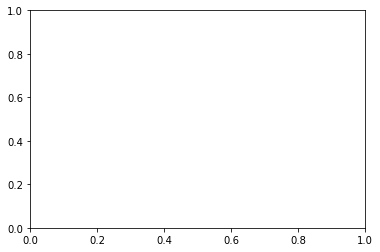

In [102]:
plt.plot(theta,test.imag)
plt.plot(theta,test1.imag,'k')
plt.plot(theta,test2.imag)
plt.plot(theta,np.zeros_like(theta),linestyle='-.', color = 'black')
plt.axvline(x = 2/3 *np.pi, linestyle='-.', color = 'black')